In [1]:
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
import itertools

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (11,6)
legend_fontsize = 16

from tqdm import tqdm
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})


## Часть первая, с блекджеком и стратегиями

### Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [10]:
env = gym.make('Blackjack-v1', natural=True)
N = 100_000

In [5]:
actions = {
    'stand': 0,
    'hit': 1
}

In [6]:
def play_basic_strategy(env):
    obs, _ = env.reset()
    player_score, deler_score, usable_ace = obs
    while player_score < 19:
        obs, reward, terminated, _, _ = env.step(actions['hit'])
        player_score, deler_score, usable_ace = obs
    obs, reward, terminated, _, _ = env.step(actions['stand'])
    return reward
    
    

Средний выигрыш при базовой стратегии 

In [209]:
np.mean([play_basic_strategy(env) for _ in range(0, N)])

-0.05803

### Реализуем метод обучения с подкреплением без модели.

In [7]:
def get_action(Q, state, A, eps):
    if np.random.random() < (1 - eps):
        pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
        action = pi[state]
    else:
        action = np.random.choice(A)
    return action
    
def Q_learning(env, A, Q, num_episodes, alpha, epsilon, gamma):
    for _ in range(num_episodes):
        state, _ = env.reset()
        end = False
        while not end:
            action = get_action(Q, state, A, epsilon)
            obs, reward, end, _, _  = env.step(action)
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[obs]) - Q[state][action])
            state = obs  
    return Q

def play_by_strategy(env, pi):
    obs, _ = env.reset()
    terminated = False
    while not terminated:
        obs, reward, terminated, _, _ = env.step(pi[obs])
    return reward
    

In [8]:
def get_all_states():
    available_usable_ace = [True, False]
    available_sums = np.arange(4, 32)
    available_cards = np.arange(1, 11)
    return list(itertools.product(available_sums, available_cards, available_usable_ace))

In [9]:
S = get_all_states()

In [220]:
Q = dict(zip(S, np.zeros((len(S), 2))))

In [221]:
alpha = 0.001
epsilon = 0.8
gamma = 0.9


Q = Q_learning(env, [0, 1], Q, num_episodes=N, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)

In [222]:
pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))

Выигрыш стратегии полученной через Q обученние

In [223]:
np.mean([play_by_strategy(env, pi) for _ in range(0, N)])

-0.05693

In [225]:
collection_rewards = []
step = 500
n_games = 100_000
S = get_all_states()
Q = dict(zip(S, np.zeros((len(S), 2))))
for i in tqdm(range(step, N, step)):
    Q = Q_learning(env, [0, 1], Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [21:51<00:00,  6.59s/it]


Text(0.5, 1.0, 'Средний выигрыш в процессе обучения')

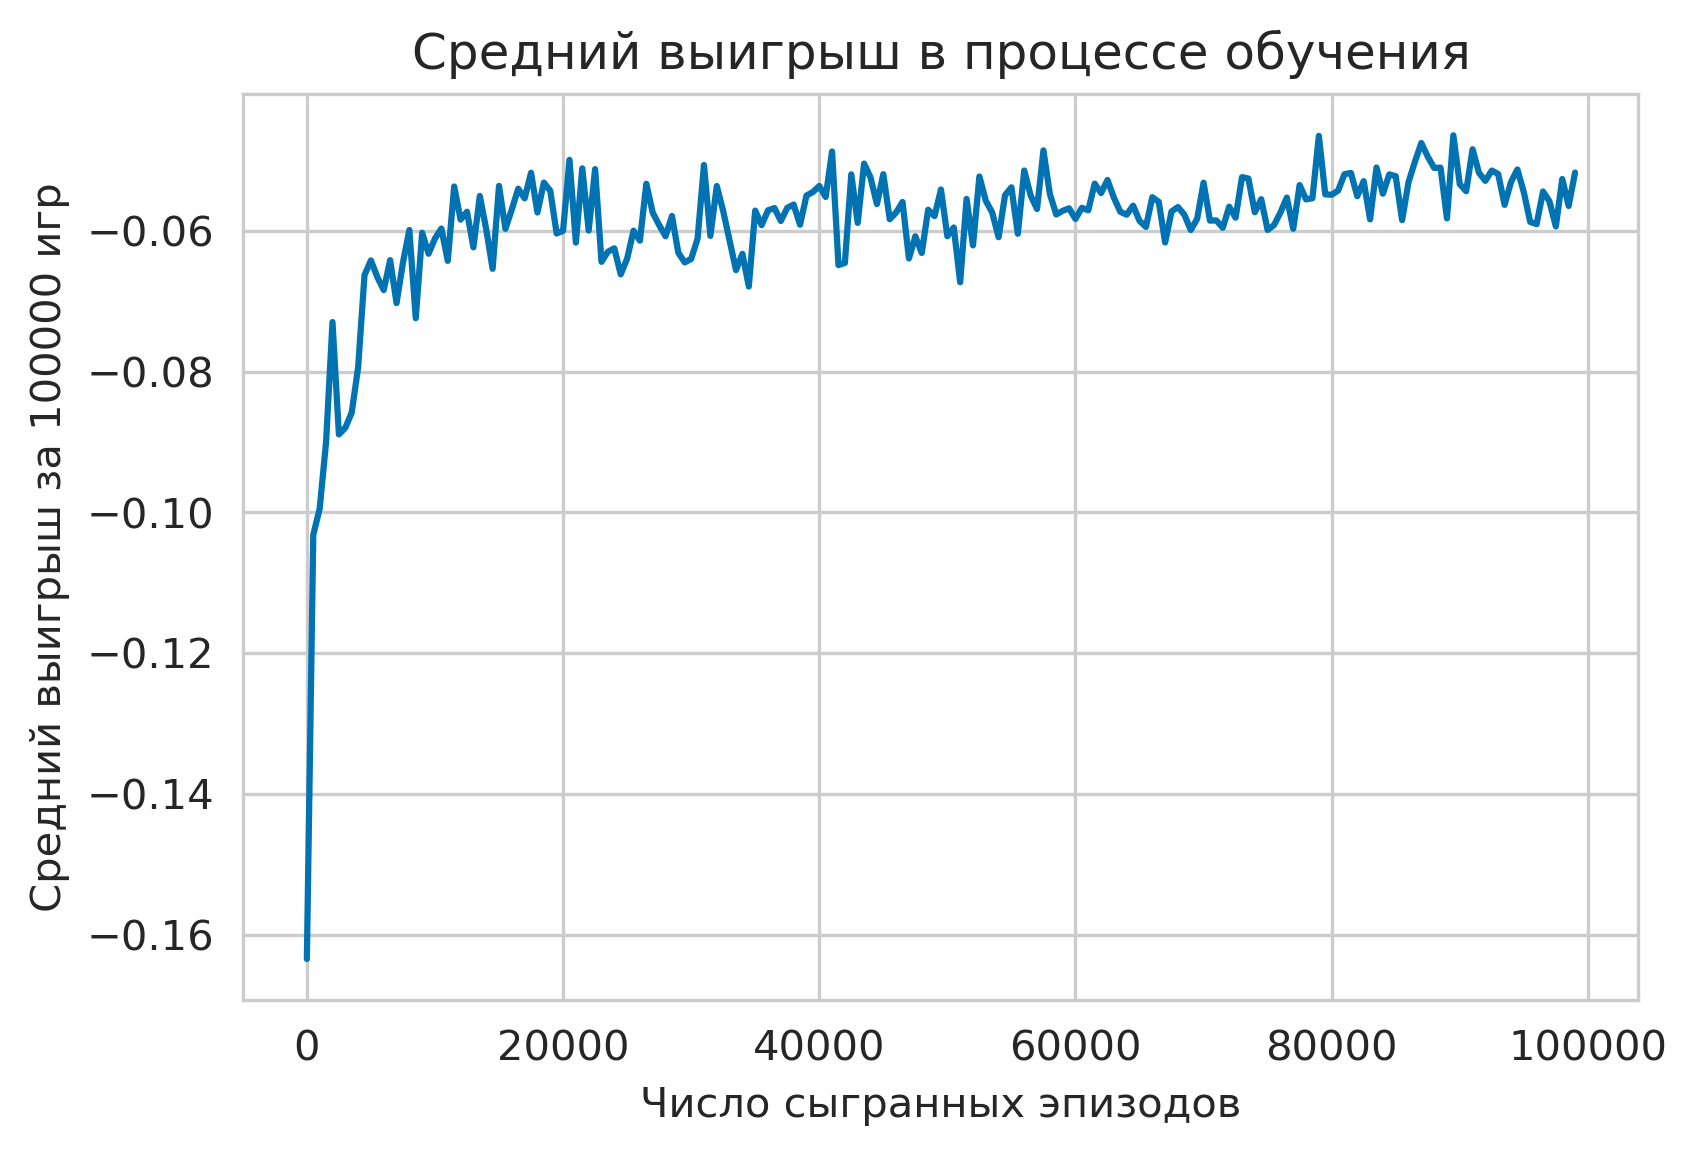

In [232]:
plt.plot(np.arange(0, len(collection_rewards)) * 500, collection_rewards)
plt.xlabel("Число сыгранных эпизодов")
plt.ylabel(f"Средний выигрыш за {n_games} игр")
plt.title("Средний выигрыш в процессе обучения")

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [2]:
from gym.envs.toy_text.blackjack import *


class BlackjackDoubleEnv(BlackjackEnv):

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        super().__init__(render_mode, natural, sab)
        self.action_space = spaces.Discrete(3)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        elif action == 1:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double: add a card to players hand, end the game, double reward
            self.player.append(draw_card(self.np_random))
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2
             
        return self._get_obs(), reward, terminated, False, {}

In [12]:
env = BlackjackDoubleEnv(natural=True)

Q = dict(zip(S, np.zeros((len(S), 3))))


alpha = 0.001
epsilon = 0.8
gamma = 0.9



In [ ]:
Q = Q_learning(env, [0, 1, 2], Q, num_episodes=N, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)

In [238]:
pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))

Выигрыш стратегии полученной через Q обученние, при возможности удвоении ставки

In [239]:
np.mean([play_by_strategy(env, pi) for _ in range(0, N)])

-0.025015

In [240]:
collection_rewards = []
step = 500
n_games = 100_000
S = get_all_states()
Q = dict(zip(S, np.zeros((len(S), 3))))
for i in tqdm(range(step, N, step)):
    Q = Q_learning(env, [0, 1, 2], Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [20:32<00:00,  6.19s/it]


Text(0.5, 1.0, 'Средний выигрыш в процессе обучения')

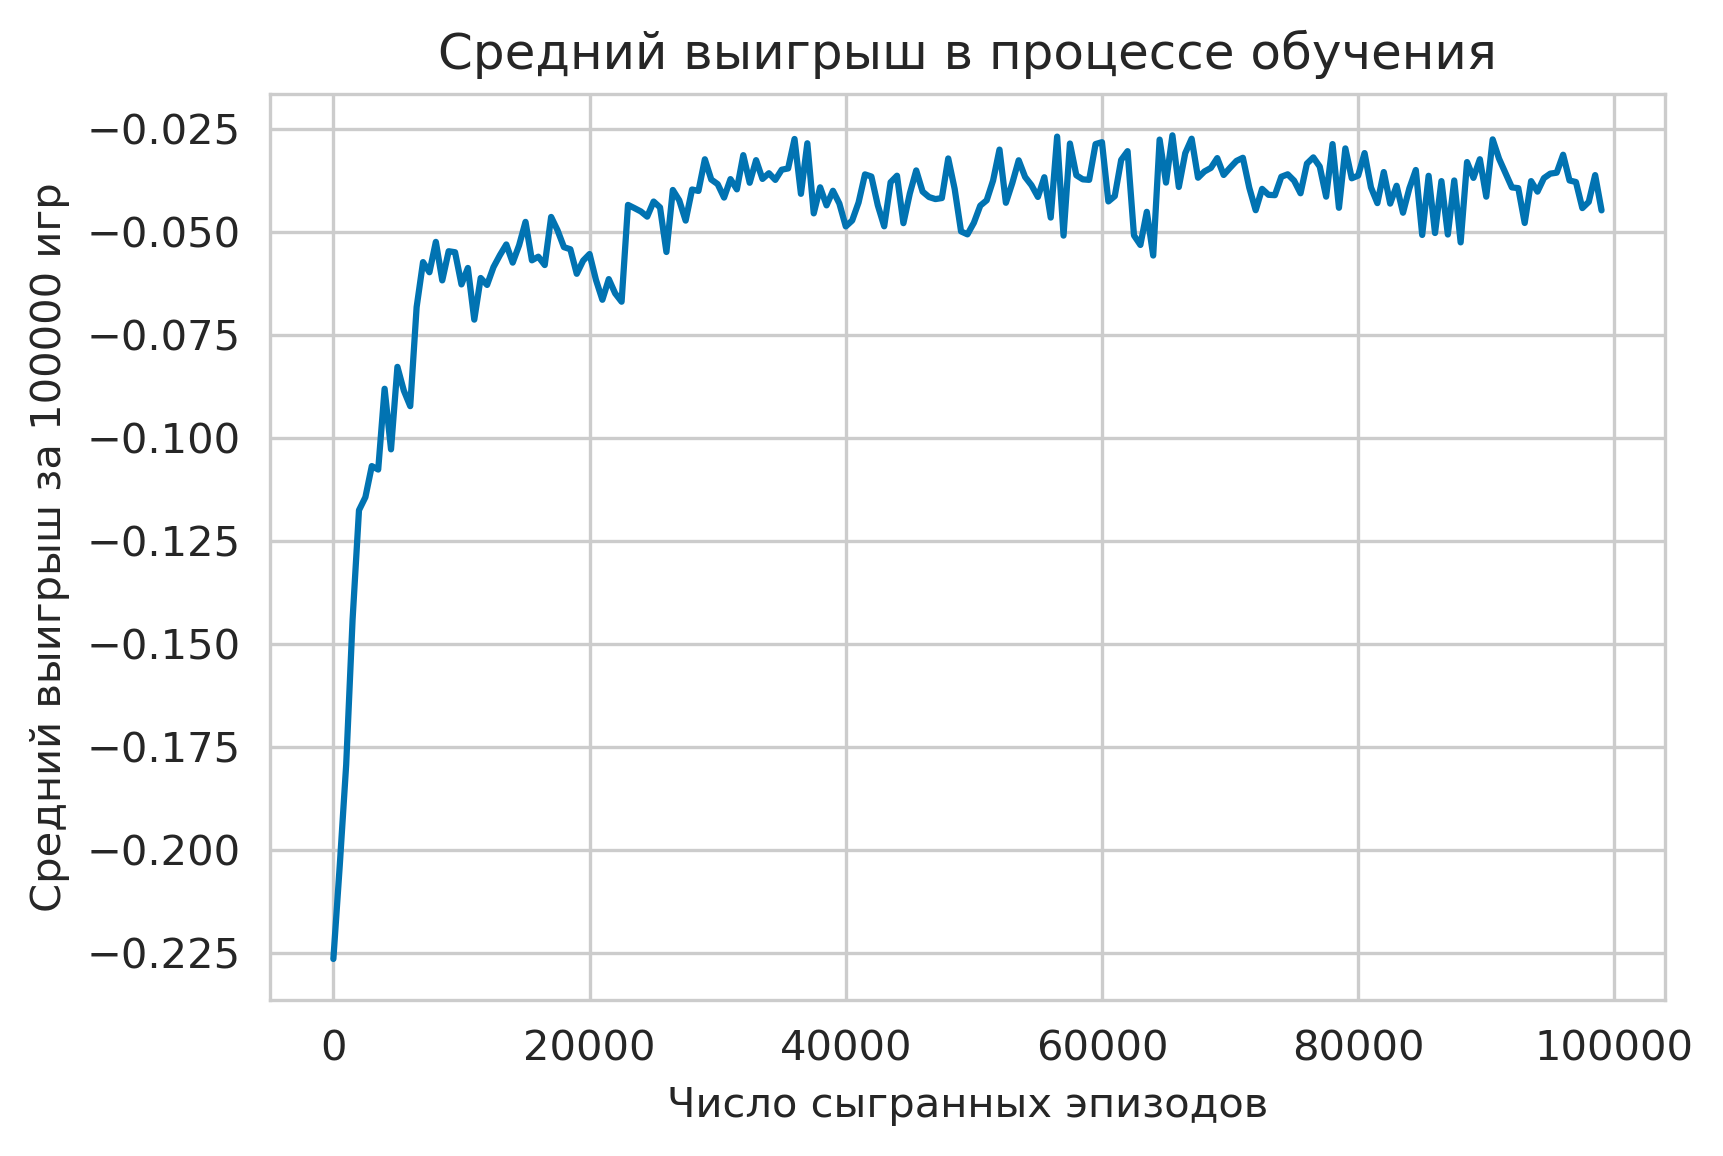

In [241]:
plt.plot(np.arange(0, len(collection_rewards)) * 500, collection_rewards)
plt.xlabel("Число сыгранных эпизодов")
plt.ylabel(f"Средний выигрыш за {n_games} игр")
plt.title("Средний выигрыш в процессе обучения")

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
- Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [3]:
class BlackjackDoubleCardsCountEnv(BlackjackEnv):

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        super().__init__(render_mode, natural, sab)
        self.action_space = spaces.Discrete(3)
        
        self.observation_space = spaces.Tuple(         # пересчитать пространство для подсчета               
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(100))
        )
        self.standart_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        # шуз на 4 колоды
        self.deck = self.standart_deck * 4
        # 'счет' карт
        self.cards_count = 0
        # числовые значения для карт
        self.mathing = {
            1: -1,
            2: 0.5,
            3: 0.5,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }
        
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        # убрать карту из колоды при раздаче
        self.deck.remove(card)
        return card


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def count(self, card):
        self.cards_count += self.mathing[card] 

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 0:  # hit: add a card to players hand and return
            # подсчитываем полученную из колоды карту
            card = self.draw_card(self.np_random)
            self.count(card)
            self.player.append(card)
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 1:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            # подсчитываем все карты диллера, кроме открытой
            for card in self.dealer[1:]:
                self.count(card)      
        else: # double: add a card to players hand, end the game, double reward
            # подсчитываем полученную из колоды карту
            card = self.draw_card(self.np_random)
            self.count(card)
            self.player.append(card)
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            # подсчитываем все карты диллера, кроме открытой
            for card in self.dealer[1:]:
                self.count(card)   
            reward = cmp(score(self.player), score(self.dealer)) * 2
             
        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cards_count)

    def reset(self):
        if len(self.deck) < 15:
            self.deck = self.standart_deck * 4
            self.cards_count = 0
        cards = self.draw_hand(self.np_random)
        self.dealer = cards
        for card in cards:
            self.count(card)  
        cards = self.draw_hand(self.np_random)
        self.player = cards
        for card in cards:
            self.count(card)  
        return self._get_obs(), {}

In [4]:
env = BlackjackDoubleCardsCountEnv(natural=True)

max_count = 4 * (1 * 1.5 + 3 * 0.5 + 2 * 1)
min_count = 4 * (4 * (-1) - 0.5 - 1)
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), np.arange(min_count, max_count, 0.5)))
Q = dict(zip(S, np.zeros((len(S), 3))))

In [14]:
#len(Q)

In [146]:
alpha = 0.0001
epsilon = 0.9
gamma = 0.9

In [250]:
Q = Q_learning(env, [0, 1, 2], Q, num_episodes=N, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)

In [251]:
pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))

Выигрыш стратегии полученной через Q обученние, при возможности удвоении ставки и подсчёте карт

In [252]:
np.mean([play_by_strategy(env, pi) for _ in range(0, N)])

-0.098085

In [254]:
collection_rewards = []
step = 500
n_games = 100_000
S = list(itertools.product(range(4, 32), range(1, 11), (True, False), np.arange(min_count, max_count, 0.5)))
Q = dict(zip(S, np.zeros((len(S), 3))))
for i in tqdm(range(step, N, step
    Q = Q_learning(env, [0, 1, 2], Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [22:13<00:00,  6.70s/it]


Text(0.5, 1.0, 'Средний выигрыш в процессе обучения')

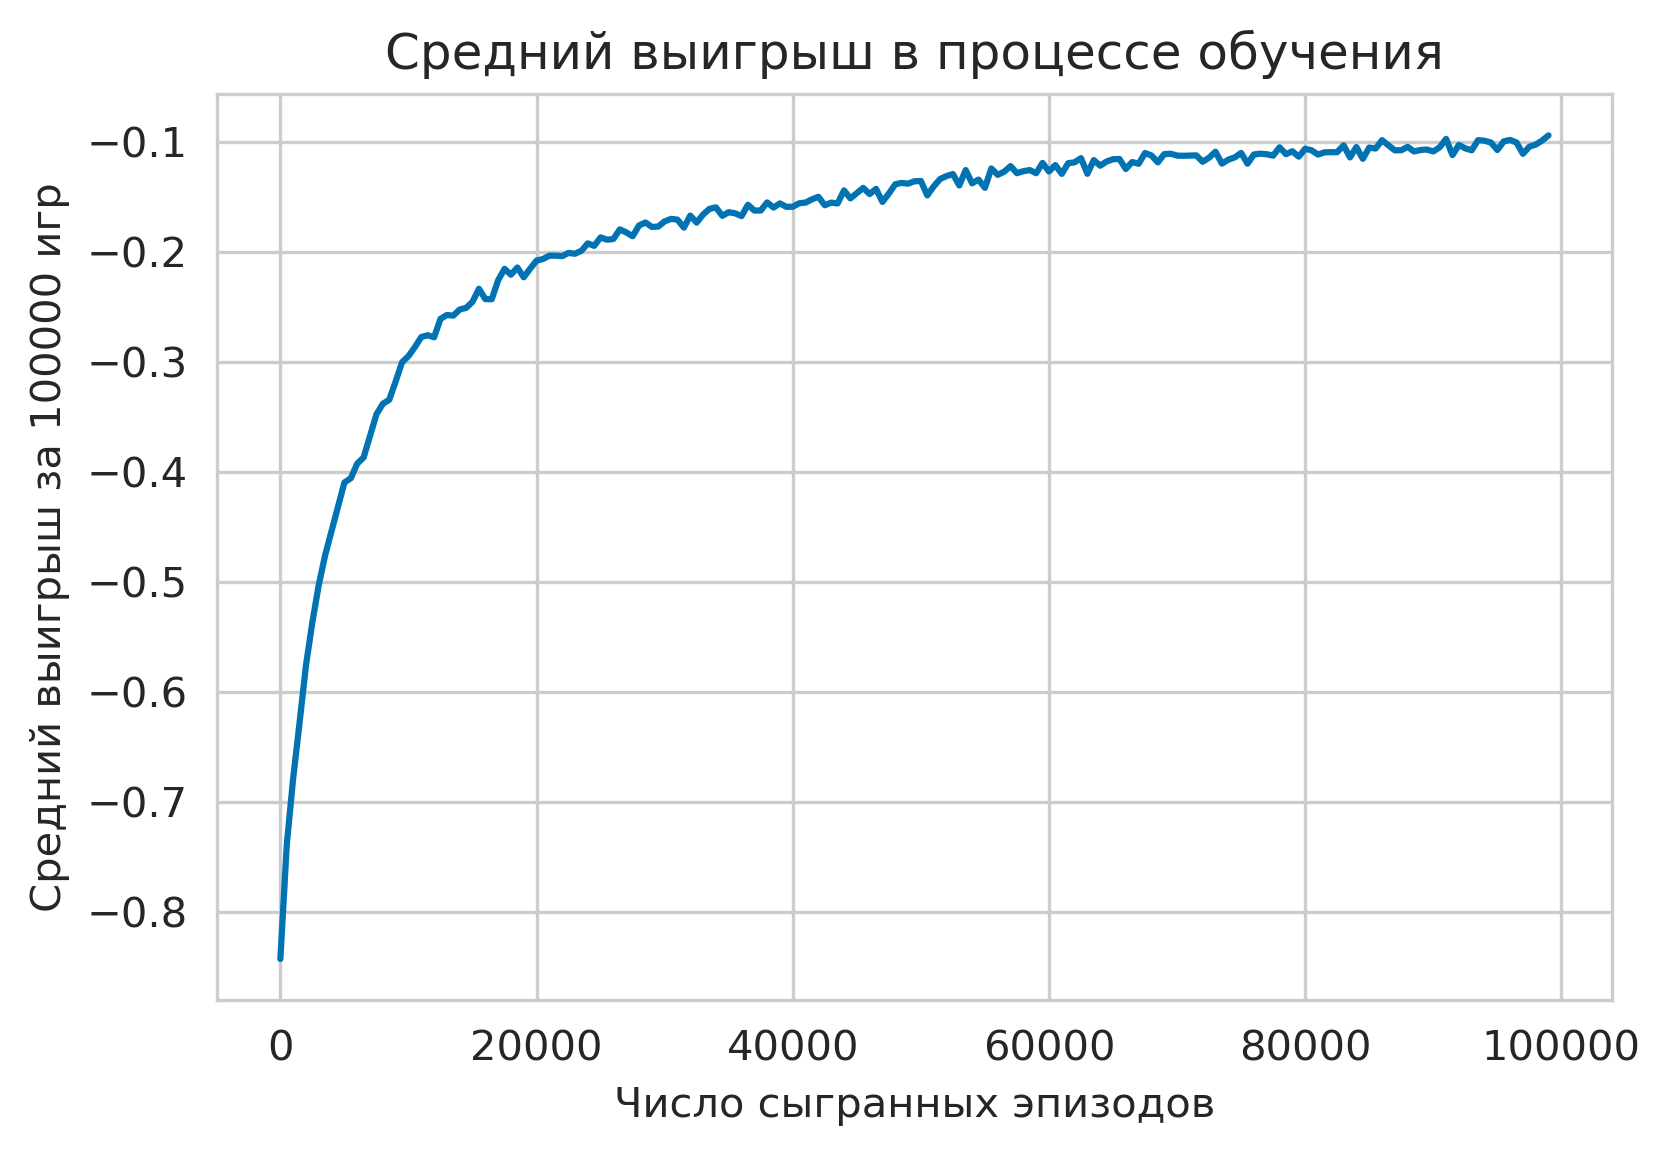

In [255]:
plt.plot(np.arange(0, len(collection_rewards)) * 500, collection_rewards)
plt.xlabel("Число сыгранных эпизодов")
plt.ylabel(f"Средний выигрыш за {n_games} игр")
plt.title("Средний выигрыш в процессе обучения")

## Тут пробовал сделать split

Ниже код, который добавляет состояния в функцию Q, когда это состояние появляется в результате обучения, в этоги выйгрышь как у случайной стратегии, но учится достаточно быстро..

In [6]:
class BlackjackDoubleCardsCountEnvSplit(BlackjackEnv):

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        super().__init__(render_mode, natural, sab)
        self.action_space = spaces.Discrete(4)
        #(22, 7, False, count, MakeSplit, SecondHandValue, SecondisAce)
        self.observation_space = spaces.Tuple(         # пересчитать пространство для подсчета               
            (spaces.Discrete(34), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(100), spaces.Discrete(2), spaces.Discrete(33), spaces.Discrete(2))
        )
        self.standart_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        # шуз на 4 колоды
        self.deck = self.standart_deck * 4
        # 'счет' карт
        self.cards_count = 0
        # числовые значения для карт
        self.mathing = {
            1: -1,
            2: 0.5,
            3: 0.5,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }
        self.second_hand = None
        self.first_hand_done = False
        self.second_hand_done = True
    
    def _check_done(self):
        return self.first_hand_done and self.second_hand_done
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        # убрать карту из колоды при раздаче
        self.deck.remove(card)
        return card


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def count(self, card):
        self.cards_count += self.mathing[card] 

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if self.first_hand_done == False:
            if action == 0:  # hit: add a card to players hand and return
                # подсчитываем полученную из колоды карту
                card = self.draw_card(self.np_random)
                self.count(card)
                self.player.append(card)
                if is_bust(self.player):
                    done = True
                    reward = -1.0
                else:
                    done = False
                    reward = 0.0 
            elif action == 1:  # stick: play out the dealers hand, and score
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                    # Player automatically wins. Rules consistent with S&B
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 1.5
                # подсчитываем все карты диллера, кроме открытой
                for card in self.dealer[1:]:
                    self.count(card)      
            elif action == 2: # double: add a card to players hand, end the game, double reward
                # подсчитываем полученную из колоды карту
                card = self.draw_card(self.np_random)
                self.count(card)
                self.player.append(card)
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                # подсчитываем все карты диллера, кроме открытой
                for card in self.dealer[1:]:
                    self.count(card)   
                reward = cmp(score(self.player), score(self.dealer)) * 2
            else: # make split
                self.player, self.second_hand = self.player[: 1], self.player[1: ]
                self.first_hand_done = False
                self.second_hand_done = False
                reward = 0.0
            if action != 3:
                self.first_hand_done = done
            return self._get_obs(), reward, self._check_done(), False, {}
        if self.first_hand_done == True and self.second_hand_done == False:
            if action == 0:  # hit: add a card to second_hand hand and return
                #print("test ac 0")
                # подсчитываем полученную из колоды карту
                card = self.draw_card(self.np_random)
                self.count(card)
                self.second_hand.append(card)
                if is_bust(self.second_hand):
                    done = True
                    reward = -1.0
                else:
                    done = False
                    reward = 0.0
                self.second_hand_done = done
            elif action == 1:  # stick: play out the dealers hand, and score
                #print("test ac 1")
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = cmp(score(self.second_hand), score(self.dealer))
                if self.sab and is_natural(self.second_hand) and not is_natural(self.dealer):
                    # second_hand automatically wins. Rules consistent with S&B
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.second_hand)
                    and reward == 1.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 1.5
                # подсчитываем все карты диллера, кроме открытой
                for card in self.dealer[1:]:
                    self.count(card)      
                self.second_hand_done = done
            elif action == 2: # double: add a card to second_hand, end the game, double reward
                #print("test ac 2")
                # подсчитываем полученную из колоды карту
                card = self.draw_card(self.np_random)
                self.count(card)
                self.second_hand.append(card)
                done = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                # подсчитываем все карты диллера, кроме открытой
                for card in self.dealer[1:]:
                    self.count(card)   
                reward = cmp(score(self.second_hand), score(self.dealer)) * 2
                self.second_hand_done = done
            return self._get_obs(), reward, self._check_done(), False, {}
    
    def _check_split(self):
        if self.second_hand == None:
            if len(self.player) == 2:
                if self.player[-1] == self.player[0]:
                    return True
        return False
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cards_count, 
                self._check_split(),
                sum_hand(self.second_hand) if self.second_hand != None else None, 
                usable_ace(self.second_hand) if self.second_hand != None else False)

    def reset(self):
        if len(self.deck) < 15:
            self.deck = self.standart_deck * 4
            self.cards_count = 0
        self.second_hand = None
        self.first_hand_done = False
        self.second_hand_done = True
        cards = self.draw_hand(self.np_random)
        self.dealer = cards
        for card in cards:
            self.count(card)  
        cards = self.draw_hand(self.np_random)
        self.player = cards
        for card in cards:
            self.count(card)  
        return self._get_obs(), {}

In [7]:
def get_action(Q, state, A, eps):
    if (np.random.random() < (1 - eps) and state in Q.keys()):
        #print(Q)
        pi = dict(zip(Q.keys(), np.argmax(list(Q.values()), axis=1)))
        #print(f"Pi {pi}")
        action = pi[state]
    else:
        action = np.random.choice(A)
    return action
    
def Q_learning(env, Q, num_episodes, alpha, epsilon, gamma):
    for _ in range(num_episodes):
        state, _ = env.reset()
        end = False
        #print(f"State {state}")
        if state not in Q:
            if state[4]:
                Q[state] = [0, 0, 0, 0]
            else:
                Q[state] = [0, 0, 0, -10000]
        while not end:
            A = [0, 1, 2, 3] if state[4] else [0, 1, 2]
            action = get_action(Q, state, A, epsilon)
            #print(f"Action {action}")
            #print(action)
            output = env.step(action)

            #print(f"Output {output}")
            obs, reward, end, _, _  = output
            if obs not in Q:
                if obs[4]:
                    Q[obs] = [0, 0, 0, 0]
                else:
                    Q[obs] = [0, 0, 0, -10000]
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[obs]) - Q[state][action])
            state = obs  
    return Q

def play_by_strategy(env, pi):
    obs, _ = env.reset()
    if obs not in pi:
        pi[obs] = np.random.choice([0, 1, 2, 3]) if obs[4] else np.random.choice([0, 1, 2])
    terminated = False
    while not terminated:
        obs, reward, terminated, _, _ = env.step(pi[obs])
        if obs not in pi:
            pi[obs] = np.random.choice([0, 1, 2, 3]) if obs[4] else np.random.choice([0, 1, 2])
    return reward
    

In [8]:
np.random.choice([0, 1, 2, 3])

1

In [13]:
env = BlackjackDoubleCardsCountEnvSplit(natural=True)

collection_rewards = []
step = 500
n_games = 10000
num_episodes = 0
Q = {}
for i in tqdm(range(step, N, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [21:26<00:00,  6.46s/it]


In [15]:
step = 500
n_games = 10000
num_episodes = 0
for i in tqdm(range(step, N, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [23:31<00:00,  7.09s/it]


In [19]:
step = 500
n_games = 10000
num_episodes = 0
for i in tqdm(range(step, N, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [25:01<00:00,  7.55s/it]


In [20]:
step = 500
n_games = 10000
num_episodes = 0
for i in tqdm(range(step, N, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████████| 199/199 [26:16<00:00,  7.92s/it]


In [24]:
step = 500
n_games = 1000
num_episodes = 0
for i in tqdm(range(step, N * 10, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|█████████████████████████████████████| 1999/1999 [5:41:17<00:00, 10.24s/it]


In [30]:
#Q.values()

Text(0.5, 1.0, 'Средний выигрыш в процессе обучения')

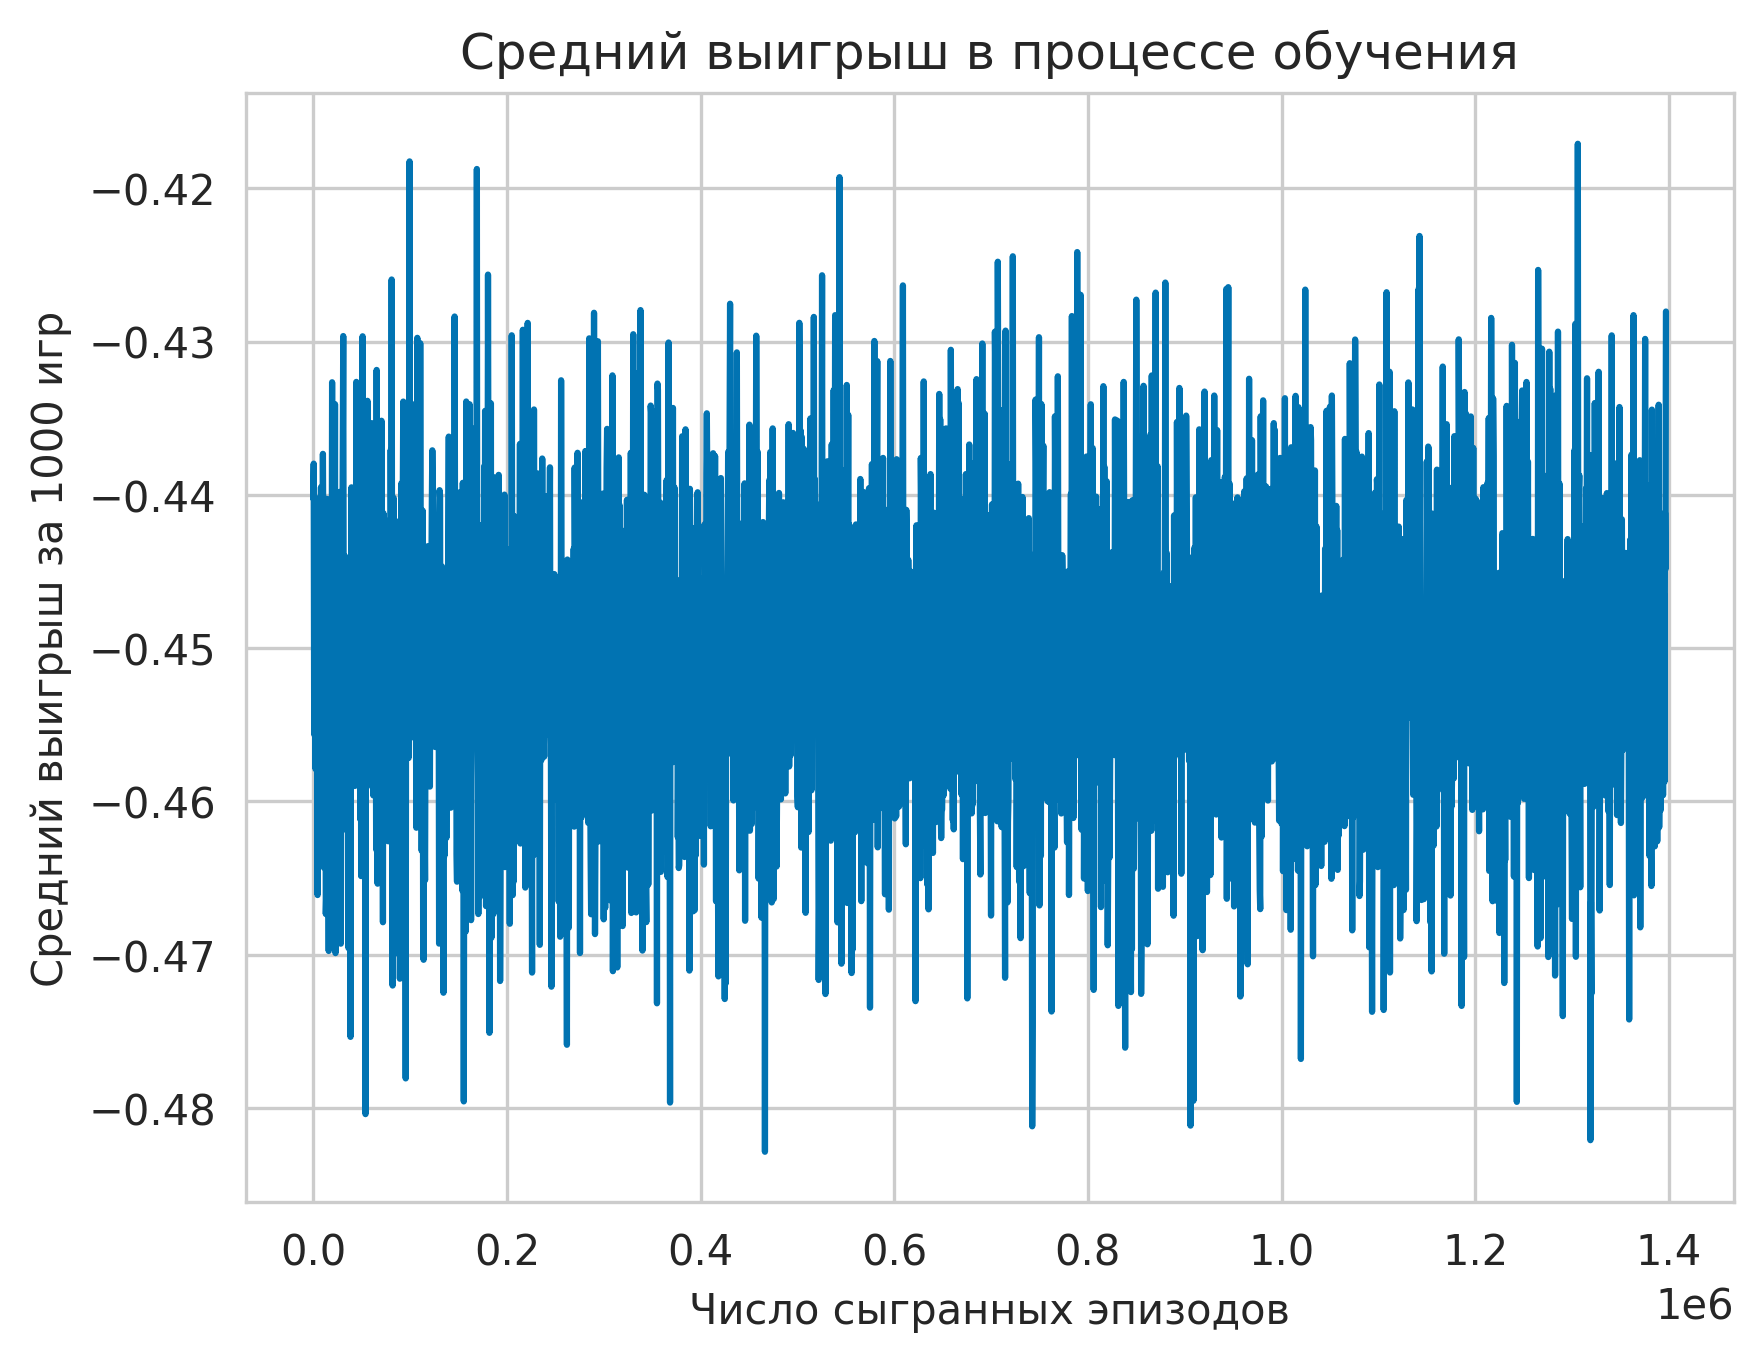

In [26]:
plt.plot(np.arange(0, len(collection_rewards)) * 500, collection_rewards)
plt.xlabel("Число сыгранных эпизодов")
plt.ylabel(f"Средний выигрыш за {n_games} игр")
plt.title("Средний выигрыш в процессе обучения")

Ниже код, который поместил все состояния в функцию Q, и потом уже обучается, очень долго учится но функция выйгрыша немного увеличилась, но выйграть не получилось...

In [274]:
collection_rewards = []
step = 500
n_games = 10000
num_episodes = 0
for i in tqdm(range(step, N, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [14:21:43<00:00, 259.82s/it]


Text(0.5, 1.0, 'Средний выигрыш в процессе обучения')

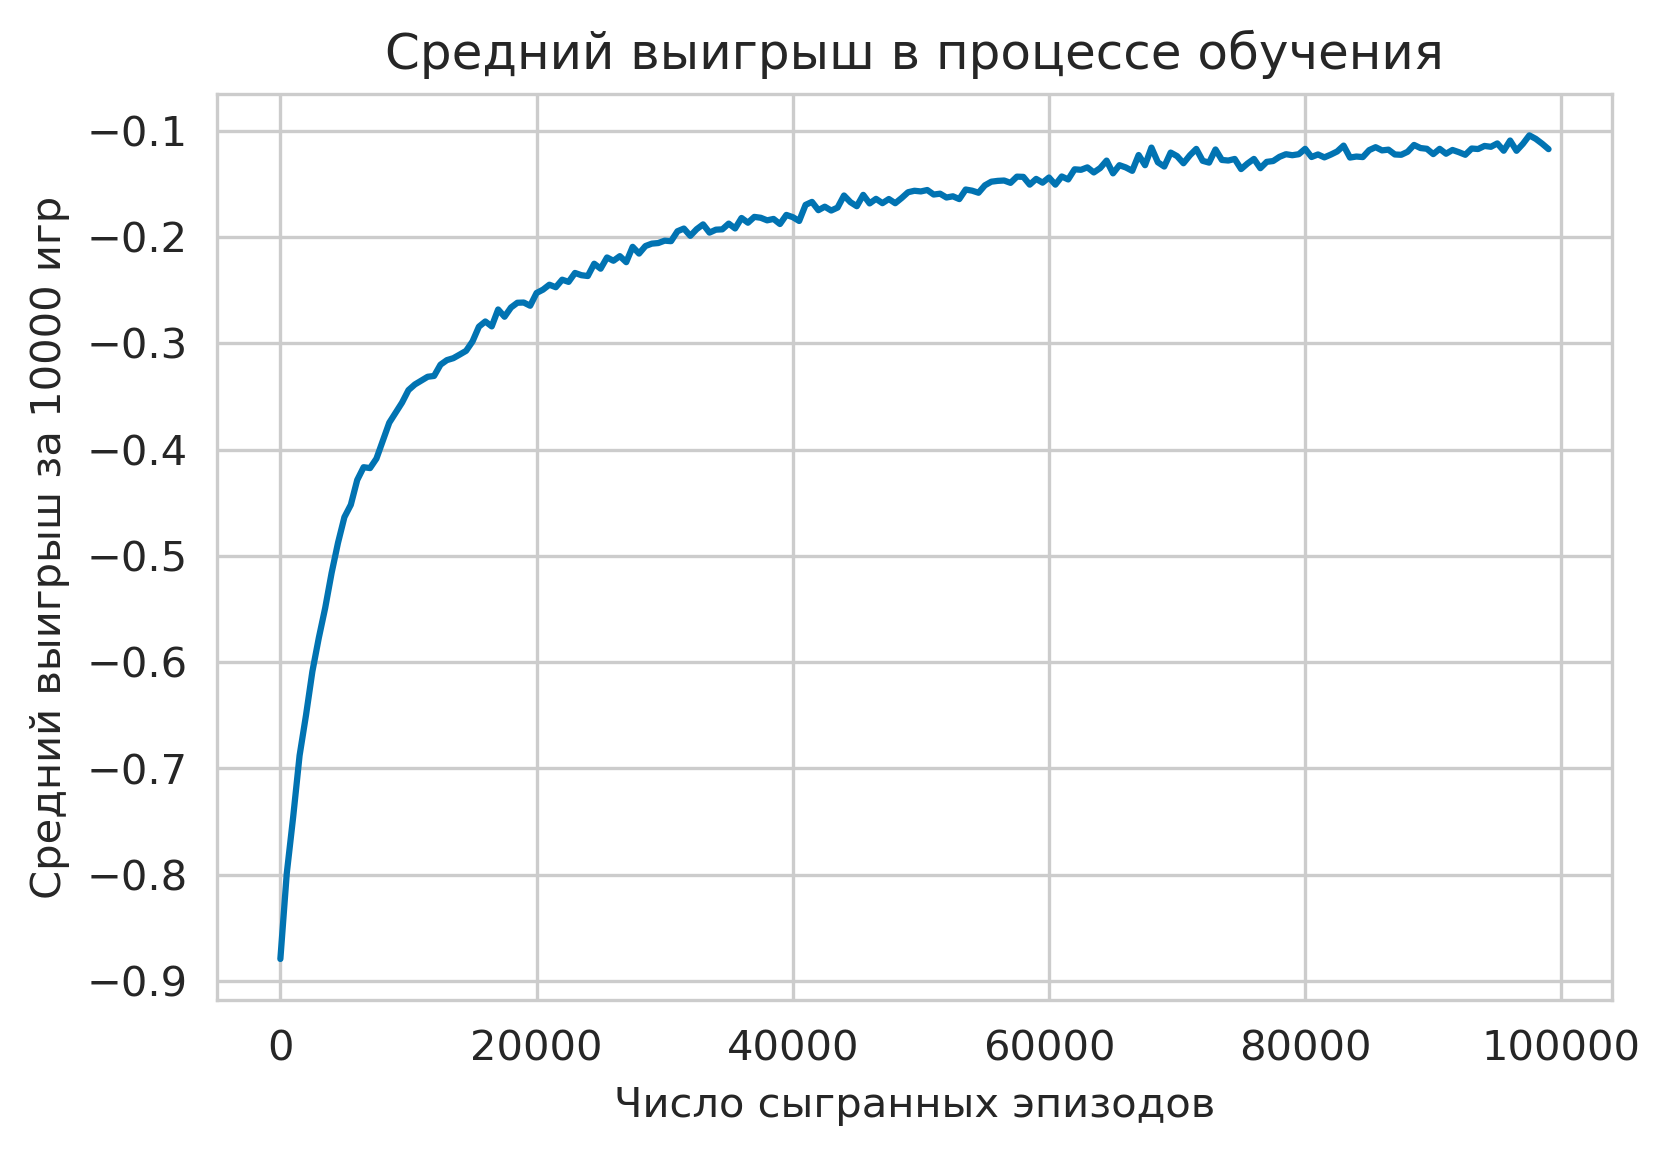

In [275]:
plt.plot(np.arange(0, len(collection_rewards)) * 500, collection_rewards)
plt.xlabel("Число сыгранных эпизодов")
plt.ylabel(f"Средний выигрыш за {n_games} игр")
plt.title("Средний выигрыш в процессе обучения")

In [276]:
step = 500
n_games = 10000
num_episodes = 0
for i in tqdm(range(step, 40_000, step)):
    num_episodes += 1
    Q = Q_learning(env, Q, num_episodes=step, 
               alpha=alpha, epsilon=epsilon, gamma=gamma)
    pi = dict(zip(S, np.argmax(list(Q.values()), axis=1)))
    mean_reward = np.mean([play_by_strategy(env, pi) for _ in range(0, N)])
    collection_rewards.append(mean_reward)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [5:44:16<00:00, 261.47s/it]


Text(0.5, 1.0, 'Средний выигрыш в процессе обучения')

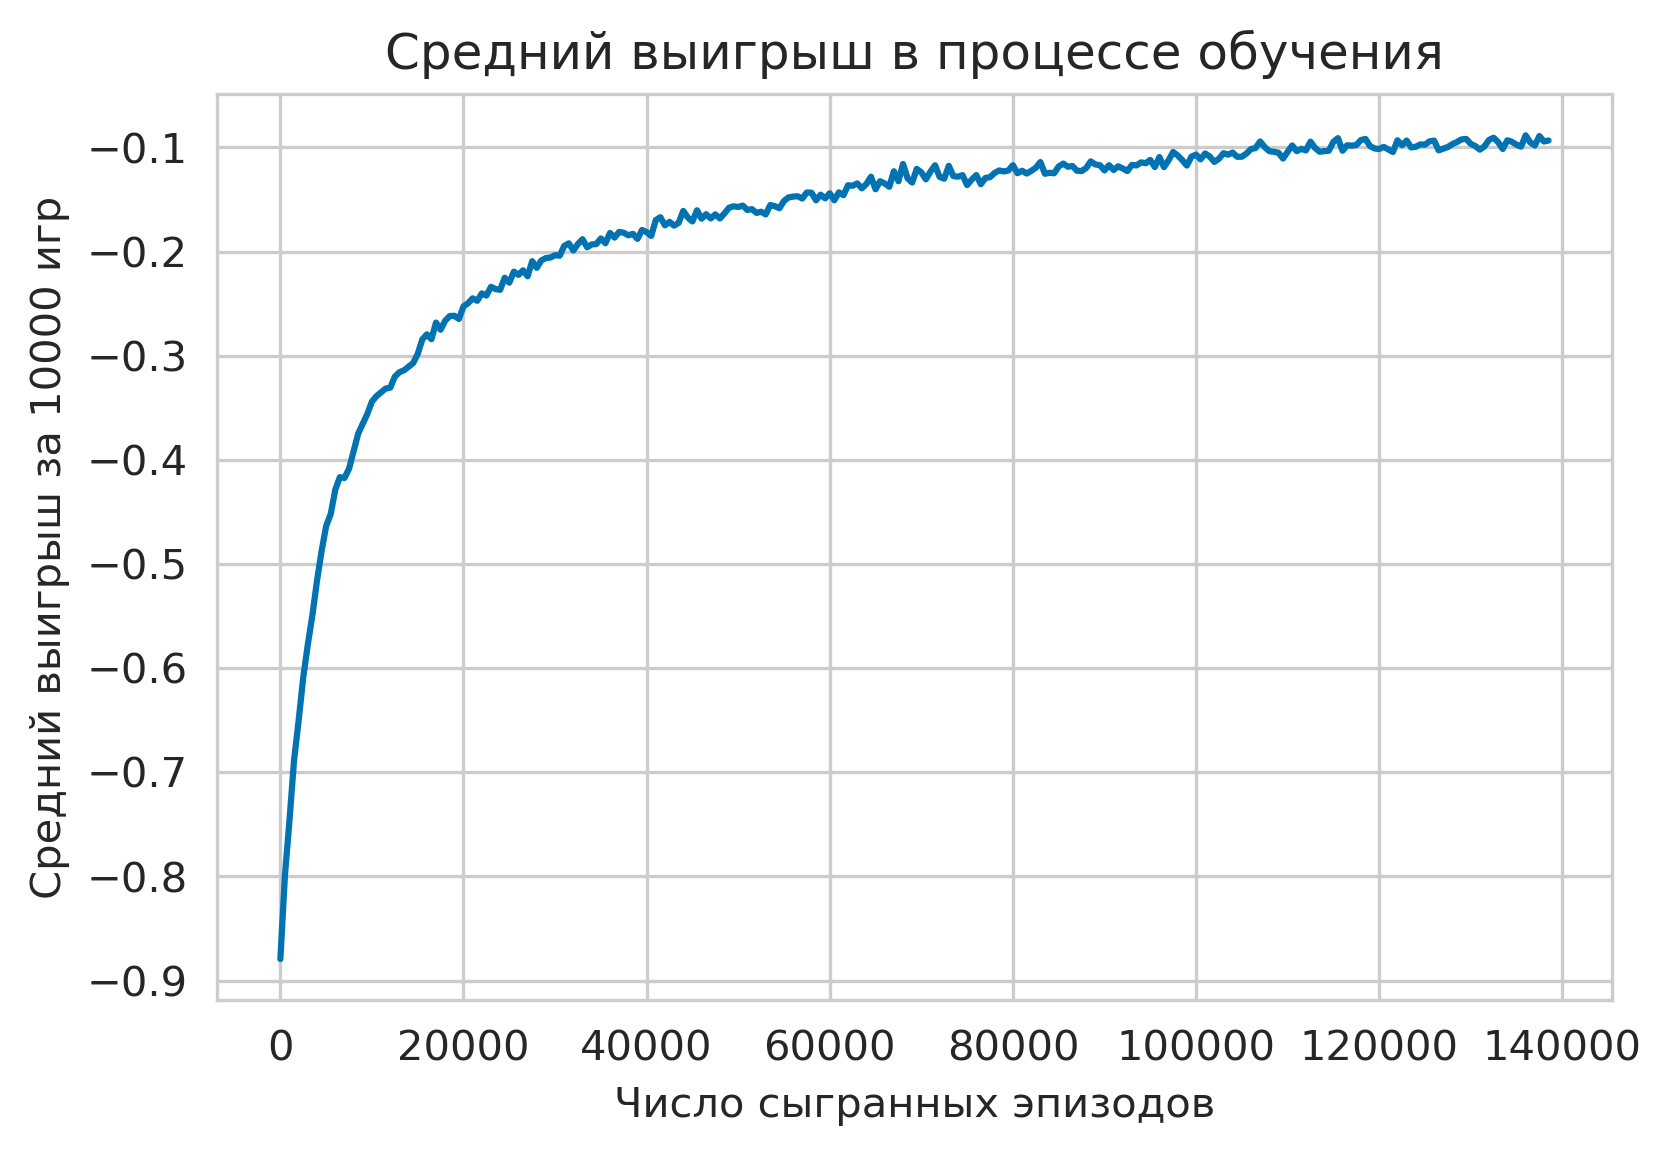

In [277]:
plt.plot(np.arange(0, len(collection_rewards)) * 500, collection_rewards)
plt.xlabel("Число сыгранных эпизодов")
plt.ylabel(f"Средний выигрыш за {n_games} игр")
plt.title("Средний выигрыш в процессе обучения")